In [1]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import os
# import get_full_info
from sklearn import linear_model as lm, metrics, ensemble as ens
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier, XGBRegressor
import warnings

2024-04-02 07:33:11.759586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# df = get_full_info.df
# df = df[df['average_home_value'] != 0]
# df.to_csv("full_info.csv", index = False)
df = pd.read_csv("full_info.csv")
df['state'] = df['state'].apply(lambda x: re.sub('District Of Columbia', 'District of Columbia', x))
df = df[df['total_population'] >= 100000]

# df_latest = get_full_info.df_realtime
# df_latest = df_latest[df_latest['average_home_value'] != 0]
# df_latest.to_csv("latest_years.csv", index = False)
df_latest = pd.read_csv("latest_years.csv")
df_latest = df_latest.drop(columns = ['rent_in_three', 'three_year_growth'])
df_latest = df_latest[df_latest['total_population'] >= 100000]

In [3]:
len(set(df_latest['place'].values.tolist()))

342

In [4]:
df = pd.get_dummies(df, prefix = 'state', columns = ['state'])
df_latest = pd.get_dummies(df_latest, prefix = 'state', columns = ['state'])

In [5]:
for col in df.columns:
    if 'state' in col:
        df[col] = df[col].apply(lambda x: 1 if x == True else 0)

In [6]:
df_latest = df_latest[df_latest['year'] == df_latest['year'].max()]

In [7]:
print('mean current value: ', df_latest['average_home_value'].mean())
print('median current value: ', df_latest['average_home_value'].median())
print('25th percentile current value: ', np.percentile(df_latest['average_home_value'], 25))
print('number 200k or less: ', len(df_latest[df_latest['average_home_value'] <= 200000]))

mean current value:  437861.66452941176
median current value:  366846.66500000004
25th percentile current value:  253298.46250000002
number 200k or less:  43


In [8]:
df_latest_candidates = df_latest.sort_values(by = 'average_home_value').drop(columns = [x for x in df_latest.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and \
                                                                                        # '3' not in x and\
                                        'roi' not in x and 'vacancy' not in x])

df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('California')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('New York')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Puerto Rico')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Hawaii')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Texas')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Florida')]
df_latest_candidates = df_latest_candidates[df_latest_candidates['average_home_value'] <= 250000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['total_population'] >= 100000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_1_years'] < 0]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_3_years'] < df_latest_candidates['vacancy_growth_last_2_years']]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_2_years'] < df_latest_candidates['vacancy_growth_last_1_years']] 
df_latest_candidates.sort_values(by = 'vacancy_rate')

,year,place,average_annual_rent,average_home_value,total_population,vacancy_rate,vacancy_growth_last_1_years,vacancy_growth_last_2_years,vacancy_growth_last_3_years
112734,2022,Green Bay city - Wisconsin,9236.04,207376.55,106846,0.038405,-0.144985,-0.226759,-0.232500
104019,2022,Broken Arrow city - Oklahoma,12686.64,241907.74,114237,0.050297,-0.087292,-0.114080,-0.115551
97658,2022,Springfield city - Missouri,9197.04,180109.81,168873,0.050461,-0.082215,-0.175844,-0.342374
89221,2022,Joliet city - Illinois,12369.72,246262.48,150221,0.057373,-0.006929,-0.104471,-0.178888
95382,2022,Warren city - Michigan,11364.36,171685.02,138588,0.063109,-0.060786,-0.183544,-0.209669
86180,2022,Pueblo city - Colorado,10124.40,234415.38,111430,0.063935,-0.082590,-0.220793,-0.318264
94849,2022,Dearborn city - Michigan,13392.72,233492.03,108414,0.071170,-0.066968,-0.164560,-0.258202
99956,2022,Las Cruces city - New Mexico,9871.32,223360.87,111273,0.071916,-0.167887,-0.253698,-0.330282
108030,2022,Clarksville city - Tennessee,11916.48,239749.65,167882,0.073616,-0.098334,-0.236165,-0.293594
90300,2022,Fort Wayne city - Indiana,9245.64,176476.01,264514,0.074725,-0.070493,-0.137034,-0.179821


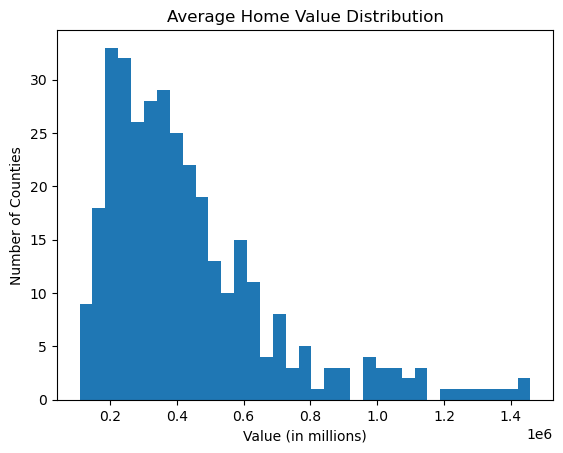

In [9]:
plt.hist(df_latest['average_home_value'], bins = 35)
plt.title("Average Home Value Distribution")
plt.xlabel("Value (in millions)")
plt.ylabel("Number of Counties")
plt.savefig("Home_Values_Dist")

In [10]:
df_latest['vacancy_rate'].mean()

0.08002348566286493

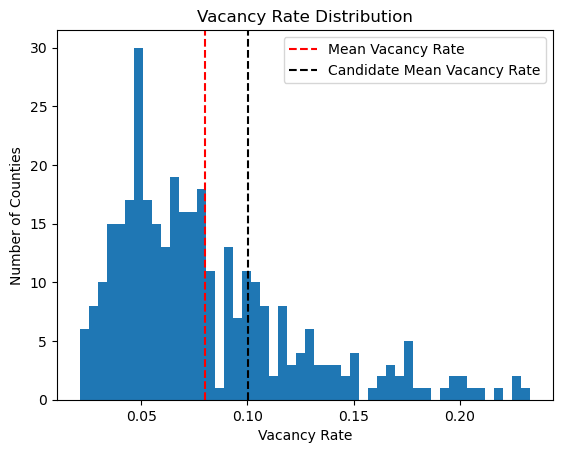

In [11]:
plt.hist(df_latest['vacancy_rate'], bins = 50)
plt.axvline(df_latest['vacancy_rate'].mean(), color = 'r', linestyle = 'dashed', label = 'Mean Vacancy Rate')
plt.axvline(df_latest_candidates['vacancy_rate'].mean(), color = 'k', linestyle = 'dashed', label = 'Candidate Mean Vacancy Rate')
plt.legend()
plt.title("Vacancy Rate Distribution")
plt.xlabel("Vacancy Rate")
plt.ylabel("Number of Counties")
plt.savefig("Vacancy_Dist")

In [12]:
print('mean current vacancy rate: ', df_latest['vacancy_rate'].mean())
print('median current vacancy rate: ', df_latest['vacancy_rate'].median())
print('25th percentile current vacancy rate: ', np.percentile(df_latest['vacancy_rate'], 25))


mean current vacancy rate:  0.08002348566286493
median current vacancy rate:  0.06812200521915104
25th percentile current vacancy rate:  0.049033343022973054


(array([ 5.,  6.,  6., 10., 16., 11., 13., 19., 23., 14., 10., 13., 16.,
        12., 14., 15., 12., 10.,  2.,  8.,  9.,  6.,  9.,  9.,  7.,  3.,
         3.,  6.,  3.,  3.,  5.,  3.,  3.,  2.,  2.,  2.,  2.,  2.,  1.,
         1.,  1.,  3.,  1.,  3.,  3.,  1.,  1.,  0.,  1.,  2.]),
 array([0.02086036, 0.02439792, 0.02793548, 0.03147305, 0.03501061,
        0.03854817, 0.04208573, 0.0456233 , 0.04916086, 0.05269842,
        0.05623598, 0.05977355, 0.06331111, 0.06684867, 0.07038623,
        0.0739238 , 0.07746136, 0.08099892, 0.08453648, 0.08807405,
        0.09161161, 0.09514917, 0.09868674, 0.1022243 , 0.10576186,
        0.10929942, 0.11283699, 0.11637455, 0.11991211, 0.12344967,
        0.12698724, 0.1305248 , 0.13406236, 0.13759992, 0.14113749,
        0.14467505, 0.14821261, 0.15175017, 0.15528774, 0.1588253 ,
        0.16236286, 0.16590042, 0.16943799, 0.17297555, 0.17651311,
        0.18005067, 0.18358824, 0.1871258 , 0.19066336, 0.19420093,
        0.19773849]),
 <BarContainer

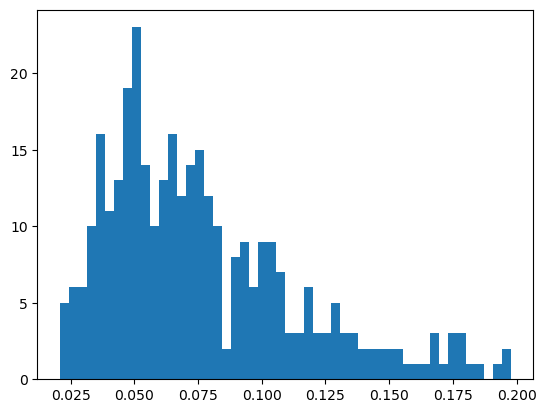

In [13]:
plt.hist(df_latest[df_latest['vacancy_rate'] < 0.2]['vacancy_rate'], bins = 50)

In [14]:
df_orig = df.copy()

In [15]:
# MAKE VALI DATA SECOND TO LAST YEAR; TEST DATA LAST YEAR; TRAIN FIRST 6
last_year = df['year'].max()
train = df[df['year'] < last_year - 4]
vali = df[df['year'] == last_year - 1]
test = df[df['year'] == last_year]

In [16]:
print('training sample - ', len(train))
print('validation sample - ', len(vali))
print('test sample - ', len(test))

training sample -  1737
validation sample -  321
test sample -  325


In [17]:
for yr in set(df['year'].values.tolist()):
    print(yr, len(df[df['year'] == yr]))

2016 315
2017 316
2018 321
2019 325
2009 272
2010 277
2011 286
2012 292
2013 303
2014 307
2015 313


In [18]:
print(len(df))
print(len(df_latest))

3327
340


In [19]:
# SCALE NON-PERCENTAGES
std_scl = StandardScaler()
train['average_annual_rent'] = std_scl.fit_transform(train[['average_annual_rent']])
train['average_home_value'] = std_scl.fit_transform(train[['average_home_value']])
train['total_population'] = std_scl.fit_transform(train[['total_population']])

vali['average_annual_rent'] = std_scl.fit_transform(vali[['average_annual_rent']])
vali['average_home_value'] = std_scl.fit_transform(vali[['average_home_value']])
vali['total_population'] = std_scl.fit_transform(vali[['total_population']])

test['average_annual_rent'] = std_scl.fit_transform(test[['average_annual_rent']])
test['average_home_value'] = std_scl.fit_transform(test[['average_home_value']])
test['total_population'] = std_scl.fit_transform(test[['total_population']])

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85602/3716576234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['average_annual_rent'] = std_scl.fit_transform(train[['average_annual_rent']])
/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85602/3716576234.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['average_home_value'] = std_scl.fit_transform(train[['average_home_value']])
/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85602/3716576234.py:5: Settin

In [20]:
# TESTING HAS SHOWN FAKE PREDS BEATS MODEL - WANNA SEE WHAT HAPPENS IF FAKE PRED IS A FEATURE
train['fake_pred'] = round(((train['average_home_value'] * (1 + train['home_val_growth_last_3_years']) - train['average_home_value']) + \
                     (
                        train['average_annual_rent'] * (1 + train['rent_growth_last_1_years']) +\
                        train['average_annual_rent'] * (1 + train['rent_growth_last_2_years']) +\
                        train['average_annual_rent'] * (1 + train['rent_growth_last_3_years'])
                     ))/train['average_home_value'], 4)

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85602/2596095845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['fake_pred'] = round(((train['average_home_value'] * (1 + train['home_val_growth_last_3_years']) - train['average_home_value']) + \


In [21]:
vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \
                     (
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_1_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_2_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_3_years'])
                     ))/vali['average_home_value'], 4)

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85602/1132831924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \


In [22]:
# #X, Y SPLITS
ex_train = train.drop(columns = ['year', 'place', 'roi'])
ex_train_scaled = std_scl.fit_transform(ex_train)
why_train = train['roi']


ex_vali = vali.drop(columns = ['year', 'place', 'roi'])
ex_vali_scaled = std_scl.fit_transform(ex_vali)
why_vali = vali['roi']

ex_test = test.drop(columns = ['year', 'place', 'roi'])
ex_test_scaled = std_scl.fit_transform(ex_test)
why_test = test['roi']

In [23]:
mse = metrics.mean_squared_error
mae = metrics.mean_absolute_error

In [24]:
print('actuals mean - ', why_vali.mean())
print('actuals standard dev - ', why_vali.std())

actuals mean -  0.3267227414330218
actuals standard dev -  0.09119363060247714


In [25]:
vali['average_home_value'] = vali['average_home_value'].astype('float')
vali['home_val_growth_last_3_years'] = vali['home_val_growth_last_3_years'].astype('float')
vali['average_annual_rent'] = vali['average_annual_rent'].astype('float')
vali['rent_growth_last_1_years'] = vali['rent_growth_last_1_years'].astype('float')
vali['rent_growth_last_2_years'] = vali['rent_growth_last_2_years'].astype('float')
vali['rent_growth_last_3_years'] = vali['rent_growth_last_3_years'].astype('float')


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85602/939463968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['average_home_value'] = vali['average_home_value'].astype('float')
/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85602/939463968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['home_val_growth_last_3_years'] = vali['home_val_growth_last_3_years'].astype('float')
/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85602/939463968.py:3: SettingWithCo

In [26]:
print('rmse - ', m.sqrt(mse(why_vali, vali['fake_pred'])))
print('mae - ', mae(why_vali, vali['fake_pred']))
vali = vali.drop(columns = ['fake_pred'])

rmse -  9.709773611513997
mae -  5.68363676012461


In [29]:
lr = lm.LinearRegression()
# TRAIN/VALI
lr_preds = lr.fit(ex_train_scaled, why_train).predict(ex_vali_scaled)
print('rmse - ', m.sqrt(mse(why_vali, lr_preds)))
print('mae - ', mae(why_vali, lr_preds))
print('r sq - ', lr.fit(ex_train_scaled, why_train).score(ex_vali_scaled, why_vali))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
lr_train_preds = lr.fit(ex_train_scaled, why_train).predict(ex_train_scaled)
print('training rmse - ', m.sqrt(mse(why_train, lr_train_preds)))
print('training mae - ', mae(why_train, lr_train_preds))
print('training r sq - ', lr.fit(ex_train_scaled, why_train).score(ex_train_scaled, why_train))

rmse -  104554978194.96968
mae -  83938238574.77193
r sq -  -1.3186072925408144e+24
training rmse -  0.06003594588724674
training mae -  0.04581017432746737
training r sq -  0.8291855103942479


In [30]:
rf = ens.RandomForestRegressor(random_state=123)

# TRAIN/VALI
rf_fit = rf.fit(ex_train, why_train)
rf_preds = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds)))
print('mae - ', mae(why_vali, rf_preds))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
rf_train_preds = rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds)))
print('training mae - ', mae(why_train, rf_train_preds))

rmse -  0.14791505395262122
mae -  0.12135831775700934
training rmse -  0.02403167092979972
training mae -  0.017643860103626948


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85602/3272181699.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)


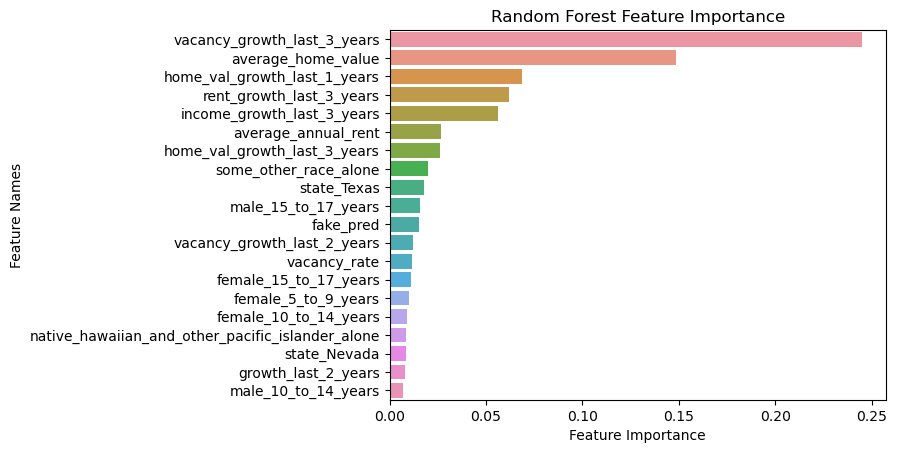

In [31]:
feature_names = ex_train.columns
importances = rf_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
rf_df = pd.DataFrame(data)
rf_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
rf_df = rf_df.head(20)

sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.savefig("feature_importance", bbox_inches = "tight")

In [32]:
%store -r rf_params

In [33]:
rf_params

{'rf__n_estimators': 50,
 'rf__max_depth': 30,
 'rf__criterion': 'friedman_mse',
 'pca__n_components': 18}

In [34]:
steps = [('pca', PCA(n_components = rf_params['pca__n_components'])), 
         ('rf', ens.RandomForestRegressor(n_estimators = rf_params['rf__n_estimators'], 
                                      max_depth = rf_params['rf__max_depth'],
                                      criterion = rf_params['rf__criterion']))]
model_rf = Pipeline(steps = steps)

# TRAIN/VALI
rf_fit = model_rf.fit(ex_train, why_train)
rf_preds_tuned = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds_tuned)))
print('mae - ', mae(why_vali, rf_preds_tuned))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
rf_train_preds_tuned = model_rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds_tuned)))
print('training mae - ', mae(why_train, rf_train_preds_tuned))

rmse -  0.20134169201381472
mae -  0.17057876279483758
training rmse -  0.03391572155658917
training mae -  0.024329886586067932


In [35]:
%store -r ada_params

In [36]:
ada_params

{'n_estimators': 150, 'learning_rate': 1}

In [37]:
ada = ens.AdaBoostRegressor(n_estimators = ada_params['n_estimators'], learning_rate = ada_params['learning_rate'])
# TRAIN/VALI
ada_fit = ada.fit(ex_train, why_train)
ada_preds = ada_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, ada_preds)))
print('mae - ', mae(why_vali, ada_preds))
               
# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
ada_train_preds = ada.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, ada_train_preds)))
print('training mae - ', mae(why_train, ada_train_preds))

rmse -  0.15277919243391433
mae -  0.12911534177152825
training rmse -  0.06713561224682117
training mae -  0.05504938955195299


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85602/3200975213.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)


Text(0, 0.5, 'Feature Names')

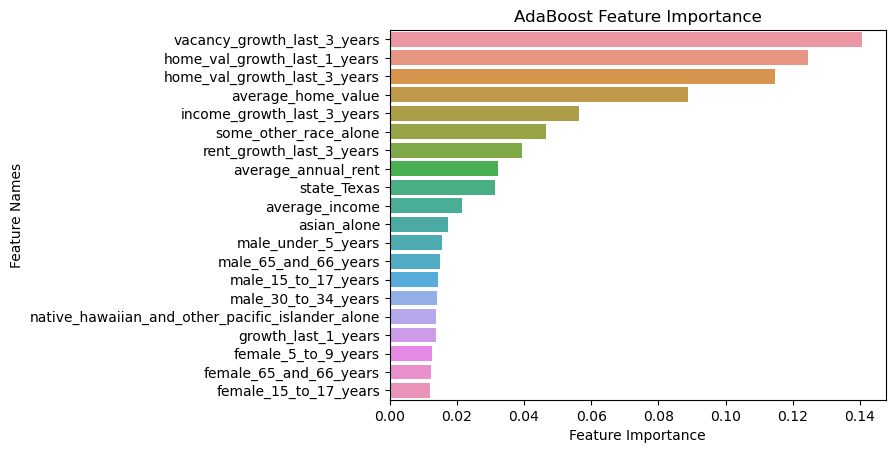

In [38]:
feature_names = ex_train.columns
importances = ada_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
ada_df = pd.DataFrame(data)
ada_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
ada_df = ada_df.head(20)

sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('AdaBoost Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
# plt.savefig("adaboost_fi_diag_chrom_level", bbox_inches = "tight")

In [39]:
%store -r xgboost_params

In [40]:
xgboost_params

{'scale_pos_weight': 1, 'max_depth': 7, 'eta': 0.1}

In [41]:
# XGBOOST IS BEING A CRYBABY ABOUT TYPES IDK WHY, BUT WHATEVER I'LL EXPLICITLY FIX LOL
ex_train['average_annual_rent'] = ex_train['average_annual_rent'].astype(float)
ex_train['average_home_value'] = ex_train['average_home_value'].astype(float)
# ex_train['average_income'] = ex_train['average_income'].astype(float)

ex_vali['average_annual_rent'] = ex_vali['average_annual_rent'].astype(float)
ex_vali['average_home_value'] = ex_vali['average_home_value'].astype(float)
ex_vali['average_income'] = ex_vali['average_income'].astype(float)


xg = XGBRegressor(scale_pos_weight = xgboost_params['scale_pos_weight'],
                   max_depth = xgboost_params['max_depth'], 
                   eta = xgboost_params['eta'])

# TRAIN/VALI
xg_fit = xg.fit(ex_train, why_train)
xg_preds = xg_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, xg_preds)))
print('mae - ', mae(why_vali, xg_preds))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
xg_train_preds = xg.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, xg_train_preds)))
print('training mae - ', mae(why_train, xg_train_preds))

rmse -  0.15375209532614803
mae -  0.12749093101806822
training rmse -  0.008217159784769132
training mae -  0.006089809913512359


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_85602/1849121513.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)


Text(0, 0.5, 'Feature Names')

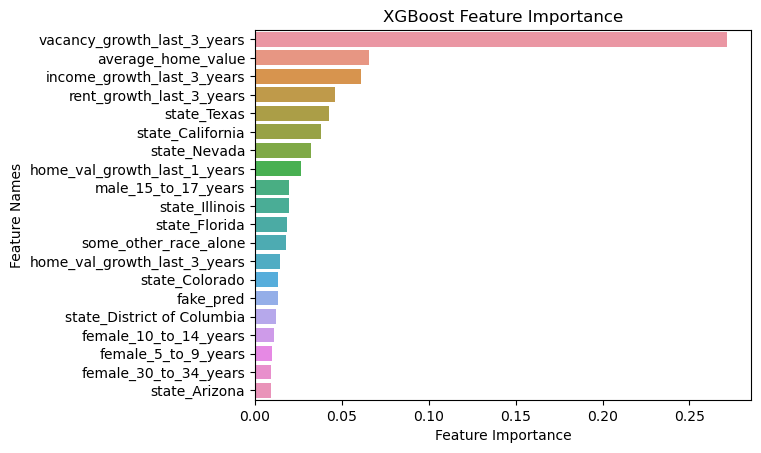

In [42]:
feature_names = ex_train.columns
importances = xg_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
xg_df = pd.DataFrame(data)
xg_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
xg_df = xg_df.head(20)

sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('XGBoost Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
# plt.savefig("adaboost_fi_diag_chrom_level", bbox_inches = "tight")

In [43]:
# SO MODEL PERFORMANCE NOT GREAT, BUT I WANNA SEE WHAT THE TOP PREDICTED AREAS WERE FOR FUN
# AFTER ALL, IF IT'S TYPICALLY OFF BUT THE VERY HIGH PREDS ARE MORE SOLID, THEN THIS ACTUALLY IS STILL USEFUL
# SINCE OUR GOAL IS TO USE THIS TO IDENTIFY TOP CANDIDATES
# RF WAS MOST PERFORMANT SO GOING TO BASE THIS ON THOSE PREDS

vali['predicted_roi'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \
                     (
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_1_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_2_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_3_years'])
                     ))/vali['average_home_value'], 4)

In [44]:
pred_check = vali.sort_values(by = 'predicted_roi', ascending = False)
pred_check = pred_check.drop(columns = [x for x in df.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and\
                                        'roi' not in x])


In [45]:
df_ec = vali.copy()
df_ec['error'] = round(df_ec['predicted_roi'] - df_ec['roi'], 3)

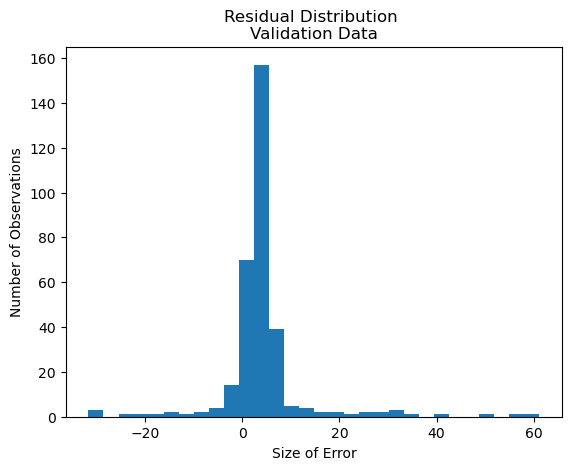

In [46]:
plt.hist(df_ec['error'], bins = 30)
plt.title("Residual Distribution \nValidation Data")
plt.xlabel("Size of Error")
plt.ylabel("Number of Observations")
plt.savefig("Model_Residuals")

In [47]:
pred_check[~pred_check['place'].str.contains('California')].head(25)

,year,place,average_annual_rent,average_home_value,total_population,roi,predicted_roi
258035,2018,Hillsboro city - Oregon,0.484550,0.026637,-0.332453,0.3754,61.5580
263581,2018,Kent city - Washington,0.288192,0.017656,-0.292150,0.4602,56.4712
255845,2018,Wilmington city - North Carolina,-0.639778,-0.040266,-0.309363,0.2390,51.2569
248674,2018,New Orleans city - Louisiana,-0.575514,-0.042424,0.159813,0.2158,42.4550
239708,2018,Anchorage municipality - Alaska,0.641013,0.058992,-0.001793,0.2142,34.0845
263318,2018,Virginia Beach city - Virginia,0.428511,0.042095,0.264319,0.2298,31.9780
242486,2018,Westminster city - Colorado,0.578573,0.065658,-0.318602,0.4284,30.8531
262001,2018,Plano city - Texas,0.571892,0.065752,-0.021720,0.3527,29.4487
253138,2018,Enterprise CDP - Nevada,0.464616,0.052362,-0.229507,0.3081,27.7377
262254,2018,Sugar Land city - Texas,1.655454,0.205330,-0.309211,0.2429,25.8059


In [48]:
# NOTE TO SELF - MADE LITTLE DIFFERENCE LIMITING TO COUNTIES W/OPZONES; SEEMS LIKE CENSUS IS REALLY THE FACTOR
pred_check[~pred_check['place'].str.contains('California')].sort_values(by = 'roi', ascending = False).head(25)

,year,place,average_annual_rent,average_home_value,total_population,roi,predicted_roi
243182,2018,Miami Gardens city - Florida,-0.058818,-0.677295,-0.318315,0.6142,0.5882
249754,2018,Detroit city - Michigan,-1.281381,-1.251685,0.656552,0.5691,3.4515
262703,2018,West Valley City city - Utah,-0.303213,-0.601803,-0.278452,0.5611,1.8635
243129,2018,Lehigh Acres CDP - Florida,-0.573409,-0.862429,-0.307444,0.5387,2.5761
261815,2018,Mesquite city - Texas,-0.378314,-0.919108,-0.264172,0.5355,1.5166
243433,2018,Spring Hill CDP - Florida,-0.527421,-0.883527,-0.327054,0.5332,2.1246
261719,2018,Lewisville city - Texas,0.005221,-0.649382,-0.332351,0.5298,0.1984
261469,2018,Grand Prairie city - Texas,-0.350014,-0.755099,-0.183221,0.5260,1.7707
243007,2018,Hialeah city - Florida,-0.244929,-0.540411,-0.103432,0.5157,1.8070
243337,2018,Port St. Lucie city - Florida,0.361159,-0.604450,-0.195906,0.5138,-1.7598


In [49]:
[place for place in pred_check.head(25)['place'].values.tolist() if \
 place in pred_check.sort_values(by = 'roi', ascending = False).head(25)['place'].values.tolist()]

['Kent city - Washington']

In [50]:
df_latest = df_latest.dropna()
df_latest = df_latest.drop(columns = [x for x in df_latest.columns if 'state_' in x])

In [51]:
df_latest['pred'] = round(((df_latest['average_home_value'] * (1 + df_latest['home_val_growth_last_3_years']) - df_latest['average_home_value']) + \
                     (
                        df_latest['average_annual_rent'] * (1 + df_latest['rent_growth_last_1_years']) +\
                        df_latest['average_annual_rent'] * (1 + df_latest['rent_growth_last_2_years']) +\
                        df_latest['average_annual_rent'] * (1 + df_latest['rent_growth_last_3_years'])
                     ))/df_latest['average_home_value'], 4)

In [52]:
df_latest.to_csv("latest_yrs_w_preds_city.csv")

In [53]:
model_candidates = df_latest.sort_values(by = 'pred', ascending = False)
model_candidates = model_candidates.drop(columns = [x for x in model_candidates.columns if 'state' in x or\
                                                   '1' in x or '2' in x in x or '4' in x or '5' in x or '6' in x or\
                                                   '7' in x or '8' in x or '9' in x or '0' in x or 'race' in x or\
                                                   'alone' in x or 'rent' in x or 'pop' in x or 'income' in x or 'val_growth' in x])
# model_candidates[model_candidates['place'].str.contains('St. Louis')]

In [54]:
df_latest['pred'].mean()

0.4454132352941177

In [55]:
model_candidates = df_latest.sort_values(by = 'pred', ascending = False)
model_candidates = model_candidates.drop(columns = [x for x in model_candidates.columns if 'state' in x])# or\
                                                   # '1' in x or '2' in x in x or '4' in x or '5' in x or '6' in x or\
                                                   # '7' in x or '8' in x or '9' in x or '0' in x or 'race' in x or\
                                                   # 'alone' in x or 'rent' in x or ('pop' in x and 'total' not in x) or 'income' in x or 'val_growth' in x])
model_candidates = model_candidates[~model_candidates['place'].str.contains('California')]
model_candidates = model_candidates[~model_candidates['place'].str.contains('New York')]
model_candidates = model_candidates[~model_candidates['place'].str.contains('Hawaii')]
model_candidates = model_candidates[~model_candidates['place'].str.contains('Puerto Rico')]
model_candidates = model_candidates[~model_candidates['place'].str.contains('Texas')]
# model_candidates = model_candidates[~model_candidates['place'].str.contains('Florida')]
model_candidates = model_candidates[model_candidates['total_population'] >= 50000]
model_candidates = model_candidates[model_candidates['average_home_value'] <= 250000]
model_candidates = model_candidates[model_candidates['average_home_value'] >= 100000]
model_candidates = model_candidates[model_candidates['pred'] > df_latest['pred'].mean()]
model_candidates

,year,place,average_annual_rent,rent_growth_last_1_years,rent_growth_last_2_years,rent_growth_last_3_years,average_home_value,home_val_growth_last_1_years,home_val_growth_last_2_years,home_val_growth_last_3_years,...,female_67_to_69_years,female_70_to_74_years,female_75_to_79_years,female_80_to_84_years,female_85_years_and_over,vacancy_rate,vacancy_growth_last_1_years,vacancy_growth_last_2_years,vacancy_growth_last_3_years,pred
87375,2022,Spring Hill CDP - Florida,13433.04,0.091776,0.169400,0.204727,236285.59,0.216245,0.338962,0.448704,...,0.021098,0.031185,0.025812,0.015323,0.014040,0.074036,0.013282,-0.168373,-0.237315,0.6457
87042,2022,Lehigh Acres CDP - Florida,14245.32,0.108930,0.177595,0.265630,242433.52,0.205884,0.352065,0.430654,...,0.013227,0.017334,0.014280,0.010704,0.005890,0.066149,-0.166528,-0.345342,-0.448433,0.6394
87203,2022,Palm Bay city - Florida,14837.16,0.120381,0.246527,0.282284,240736.19,0.206529,0.303871,0.412853,...,0.019965,0.020228,0.017891,0.014015,0.017290,0.098869,0.061148,-0.071730,-0.124744,0.6378
95060,2022,Lansing city - Michigan,9707.16,0.087578,0.141573,0.164230,135532.48,0.184707,0.283767,0.380696,...,0.012851,0.019188,0.012161,0.005514,0.008328,0.089775,-0.118749,-0.139850,-0.211044,0.6237
94856,2022,Detroit city - Michigan,9182.40,0.096149,0.149588,0.191214,108588.75,0.145532,0.211193,0.311734,...,0.015500,0.021318,0.013447,0.010660,0.012083,0.228378,-0.034894,-0.067352,-0.164923,0.6024
94849,2022,Dearborn city - Michigan,13392.72,0.131264,0.190362,0.242344,233492.03,0.155765,0.256182,0.381875,...,0.013126,0.020588,0.009169,0.007176,0.013891,0.071170,-0.066968,-0.164560,-0.258202,0.5863
92329,2022,Kansas City city - Kansas,9684.36,0.114221,0.195635,0.219816,167564.04,0.143689,0.299285,0.378511,...,0.010461,0.020445,0.013008,0.009631,0.008190,0.108515,-0.034678,-0.087680,-0.092651,0.5825
95382,2022,Warren city - Michigan,11364.36,0.072757,0.135596,0.183078,171685.02,0.186305,0.254204,0.350651,...,0.015925,0.022275,0.013702,0.015586,0.015146,0.063109,-0.060786,-0.183544,-0.209669,0.5751
94951,2022,Grand Rapids city - Michigan,12375.00,0.107264,0.170186,0.216857,223130.35,0.177883,0.282693,0.372420,...,0.011015,0.020520,0.013463,0.007229,0.013403,0.061194,-0.094956,-0.053816,-0.197504,0.5662
83622,2022,Tucson city - Arizona,11128.44,0.100070,0.159010,0.179710,245181.65,0.193678,0.292948,0.401629,...,0.015944,0.019285,0.015774,0.011208,0.012604,0.094277,-0.036671,-0.086103,-0.158108,0.5577


In [56]:
# model_candidates.to_csv("info_on_candidates_above_avg_pred.csv")

In [57]:
len(model_candidates)

29

In [58]:
model_candidates[model_candidates['place'].isin(df_latest_candidates['place'].values.tolist())].to_csv("info_on_candidates_above_avg_pred_and_vacancy_criterion.csv")


In [59]:
core_candidates = [x for x in model_candidates['place'].values.tolist() if 'Kansas City' in x or\
                   'Grand Rapids' in x or 'Tucson' in x or 'Pueblo city' in x or
                   'Columbus' in x or 'Knoxville' in x or 'Cleveland' in x or\
                   'Memphis' in x or 'Indianapolis' in x or 'Des Moines' in x or\
                   'Milwaukee' in x]

core_candidates.append('Las Cruces city - New Mexico')

In [60]:
core_candidates

['Kansas City city - Kansas',
 'Grand Rapids city - Michigan',
 'Tucson city - Arizona',
 'Pueblo city - Colorado',
 'Columbus city - Ohio',
 'Knoxville city - Tennessee',
 'Cleveland city - Ohio',
 'Memphis city - Tennessee',
 'Indianapolis city (balance) - Indiana',
 'Des Moines city - Iowa',
 'Milwaukee city - Wisconsin',
 'Las Cruces city - New Mexico']

In [61]:
df_info = df_latest.drop(columns = [x for x in df_latest.columns if x not in\
                                    ['place', 'pred',\
                                     'average_home_value', 'home_val_growth_last_3_years',\
                                     'total_population', 'growth_last_3_years',\
                                     'average_annual_rent', 'rent_growth_last_3_years',\
                                     'vacancy_rate', 'vacancy_growth_last_3_years']])
# df_info = df_info[df_info['place'].isin(core_candidates)]

In [62]:
df_info[df_info['place'].str.contains('Ohio')]

,place,average_annual_rent,rent_growth_last_3_years,average_home_value,home_val_growth_last_3_years,total_population,growth_last_3_years,vacancy_rate,vacancy_growth_last_3_years,pred
102679,Akron city - Ohio,8801.04,0.182516,136839.30,0.221742,190273,-0.039273,0.099555,-0.180341,0.4394
102887,Cincinnati city - Ohio,10251.60,0.233486,272375.26,0.282212,308870,0.024805,0.117065,-0.219205,0.4152
102896,Cleveland city - Ohio,9056.28,0.229257,121645.30,0.224443,370365,-0.038717,0.163907,-0.164313,0.4864
102910,Columbus city - Ohio,12475.44,0.228154,241646.89,0.348946,902449,0.027199,0.078788,-0.129615,0.5304
102948,Dayton city - Ohio,7851.60,0.195920,110266.32,0.290206,137305,-0.023220,0.177983,-0.172965,0.5362
103788,Toledo city - Ohio,8147.76,0.169808,118627.22,0.212056,269962,-0.024048,0.116405,-0.185431,0.4475


In [63]:
# df_latest.to_csv("latest_w_hardcode_preds_pop_limit.csv")

In [64]:
# pd.read_csv("model_and_vac_candidates.csv")

In [65]:
df['year'].max()

2019